Denoising fMRI data using aCompCor and functional connectivity estimation
================================================

This a script for group denoising and FC estimation from on longitudinal fMRI data preprocessed in fmriprep.

Step 1: Importing packages
------------------------------------------

In [17]:
%reset
%matplotlib inline

from os import listdir

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 

from sklearn import preprocessing # for normalization of confounds columns

from nilearn import datasets # for fetching atlas
from nilearn import plotting 
from nilearn import input_data
from nilearn import signal
from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure

from denoise import *

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


Step 2: Creating atlas
-------------------------------------------

In [18]:
# Loading Power ROIs coordinates

power = datasets.fetch_coords_power_2011()
power_coords = np.vstack((power.rois['x'], power.rois['y'], power.rois['z'])).T

# Creating masker file

power_spheres = input_data.NiftiSpheresMasker(
    seeds = power_coords, 
    smoothing_fwhm = 6, 
    radius = 5,
    detrend = True, 
    standardize = True,
    low_pass = 0.08, 
    high_pass = 0.009,
    t_r = 2
)

parcellation = power_spheres

Step 3: Loading data
-----------------------

In [23]:
# Loading functional data
top_dir = '/home/finc/Downloads/fmriprep/'
out_dir = '/home/finc/Downloads/fmriprep/'

sess = ['ses-1', 'ses-2', 'ses-3', 'ses-4']
tasks = ['dualnback']
subs = listdir(top_dir)

suffix = 'space-MNI152NLin2009cAsym_preproc.nii.gz'
#suffix = 'space-MNI152NLin2009cAsym_variant-smoothAROMAnonaggr_preproc.nii.gz'



Step 4: Obtaining timeseries from ROIs
---------------------------
Creating 5D matrix with mean timeseries within each ROI 

In [31]:
subs = listdir(top_dir)

timeseries_all = np.zeros((len(subs), len(sess), len(tasks), 340, 264))

for sub in range(len(subs)):
    for ses in range(len(sess)):
        for task in range(len(tasks)):
            
            sub_dir = top_dir + subs[sub] + '/' + sess[ses] + '/func/'
            data = sub_dir + subs[sub] + '_' + sess[ses] + '_task-' + tasks[task] + '_bold_' + suffix
            
            # Loading confound data
            confounds_path = sub_dir + subs[sub] + '_' + sess[ses] + '_task-' + tasks[task] + '_bold_confounds.tsv'
            confounds = pd.read_csv(confounds_path, delimiter = '\t')

            # Select columns of interest
            confounds_motion = confounds[confounds.filter(regex='X|Y|Z|RotX|RotY|RotZ').columns]
            confounds_anat = confounds[confounds.filter(regex='CSF|WhiteMatter|aCompCor|Cos').columns]
            confounds_fd =  confounds[confounds.filter(regex='Framewise').columns]

            # Calculate 24 fristom motion parameters
            confounds_motion_24 =  motion_24_friston(confounds_motion)

            # Detect outliers 
            confounds_scrub = scrubbing(confounds_fd, before = False)

            # Standardize confounds
            confounds_anat = standardize(confounds_anat)

            # Add scrubbing columns
            confounds_clean = pd.concat([confounds_anat, confounds_motion_24, confounds_scrub], axis = 1)

            # Save preprocessed confound file
            confounds_clean.to_csv(sub_dir + 'confounds_' + tasks[task] + '_clean_acompcor.csv', sep = ',', index = False)
            confounds_clean_path = sub_dir + 'confounds_' + tasks[task] + '_clean_acompcor.csv'
                     
            timeseries = parcellation.fit_transform(data, confounds = confounds_clean_path)
            
            timeseries_all[sub, ses, task, :, :] = timeseries
            
np.save(out_dir + 'LearningBrain_all_timeseries_aCompCor_power.npy', timeseries_all)

/home/finc/Dropbox/Projects/LearningBrain/code/denoise.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  motion_24_friston[col + '_td'] = temp_diff
/home/finc/Dropbox/Projects/LearningBrain/code/denoise.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  motion_24_friston[col + '_sqrt'] = sqrt
/home/finc/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/sta

/home/finc/Dropbox/Projects/LearningBrain/code/denoise.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  motion_24_friston[col + '_td'] = temp_diff
/home/finc/Dropbox/Projects/LearningBrain/code/denoise.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  motion_24_friston[col + '_sqrt'] = sqrt
/home/finc/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/sta

Step 5: Creating task conditions vectors
-----------------------------------------------------------

In [50]:
onsets_1back = np.array([4, 72, 140, 208, 276, 344, 412, 480, 548, 616])
onsets_2back = np.array([38, 106, 174, 242, 310, 378, 446, 514, 582, 650])
vol_num = 340

TR = 2
duration = 30

vector_n_back = np.zeros((vol_num, 3))

for i in range(len(vector_n_back)):
    if i in onsets_1back/TR:
        for k in range(int(duration/TR)):
            vector_n_back[i + k, 0] = 1
    if i in onsets_2back/TR:
        for k in range(int(duration/TR)):
            vector_n_back[i + k, 1] = 1
    else:
        continue
        
            
for i in range(len(vector_n_back)):
    if vector_n_back[i,0] == 0 and vector_n_back[i,1] == 0:
        vector_n_back[i,2] = 1
        
dual1back = vector_n_back[:,0].astype(bool)
dual2back = vector_n_back[:,1].astype(bool)

Step 6: Obtaining corelation matrices
---------------------------
Creating 5D matrix with static corelation matrices for each task condition 

In [57]:
correlarion_matrices_dual = np.zeros((len(subs), len(sess), 2, len(timeseries_all[0, 0, 0, 0, : ]), len(timeseries_all[0, 0, 0, 0, : ])))


for sub in range(len(timeseries_all[:, 0, 0, 0, 0])):
    for ses in range(len(timeseries_all[0,:,0,0,0])):                 
        timeseries_dual1back = timeseries_all[sub, ses, 0, dual1back, :]
        timeseries_dual2back = timeseries_all[sub, ses, 0, dual2back, :]
        
        correlation_measure = ConnectivityMeasure(kind = 'correlation')
        fc1 = correlation_measure.fit_transform([timeseries_dual1back])[0]
        np.fill_diagonal(fc1, 0)
        
        fc2 = correlation_measure.fit_transform([timeseries_dual2back])[0]
        np.fill_diagonal(fc2, 0)
                     
        correlarion_matrices_dual[sub, ses, 0, :, :] = fc1
        correlarion_matrices_dual[sub, ses, 1, :, :] = fc2


np.save(out_dir + 'LearningBrain_matrices_dual_aCompCor_power.npy', correlarion_matrices_dual)      

Step 7: Plotting
---------------------------

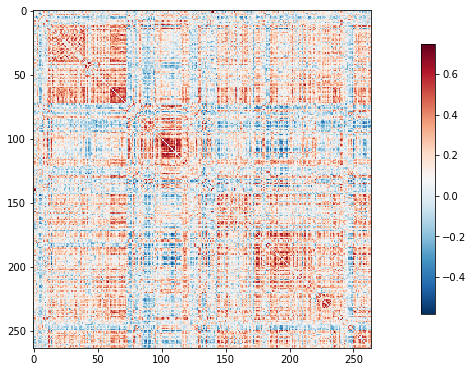

In [56]:
# 1-back

plotting.plot_matrix(correlarion_matrices_dual[1, 1, 0, :, :])

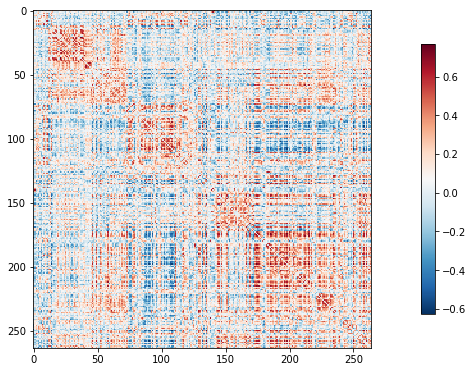

In [55]:
# 2-back

plotting.plot_matrix(correlarion_matrices_dual[1, 1, 1, :, :])